In [1]:
#import everything that we need

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
#read in the initial csv

df = pd.read_csv('nhl-shots-2021.csv')
df.head()

,game_id,description,shot_outcome,period,period_seconds_remaining,game_seconds_remaining,home_score,away_score,home_name,away_name,...,empty_net,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,x_fixed,y_fixed,shot_distance,shot_angle
0,2021020001,Steven Stamkos Wrist Shot saved by Tristan Jarry,SHOT,1,1137,3537,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Steven.Stamkos,Shooter,Tristan.Jarry,Goalie,EV,61.0,-32.0,42.5,48.8
1,2021020001,Zach Bogosian shot blocked shot by Brock McGinn,BLOCKED_SHOT,1,1115,3515,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Zach.Bogosian,Shooter,Brock.McGinn,Blocker,EV,60.0,-17.0,NaN,NaN
2,2021020001,Brock McGinn Wrist Shot saved by Andrei Vasile...,SHOT,1,1096,3496,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Brock.McGinn,Shooter,Andrei.Vasilevskiy,Goalie,EV,-65.0,19.0,30.6,38.4
3,2021020001,Jan Rutta Wrist Shot saved by Tristan Jarry,SHOT,1,1079,3479,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Jan.Rutta,Shooter,Tristan.Jarry,Goalie,EV,-8.0,-27.0,100.7,15.6
4,2021020001,Danton Heinen Wrist Shot saved by Andrei Vasil...,SHOT,1,1033,3433,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Danton.Heinen,Shooter,Andrei.Vasilevskiy,Goalie,EV,-60.0,-4.0,29.3,7.9


In [3]:
#clean dataset of unneeded things

del df['game_id']
del df['period_seconds_remaining']
del df['away_name']
del df['event_goalie_name']
del df["event_player_1_name"]
del df["event_player_2_name"]
del df["event_player_1_type"]
del df["event_player_2_type"]
df.head()

,description,shot_outcome,period,game_seconds_remaining,home_score,away_score,home_name,event_team,empty_net,strength_code,x_fixed,y_fixed,shot_distance,shot_angle
0,Steven Stamkos Wrist Shot saved by Tristan Jarry,SHOT,1,3537,0,0,Tampa Bay Lightning,Tampa Bay Lightning,NaN,EV,61.0,-32.0,42.5,48.8
1,Zach Bogosian shot blocked shot by Brock McGinn,BLOCKED_SHOT,1,3515,0,0,Tampa Bay Lightning,Tampa Bay Lightning,NaN,EV,60.0,-17.0,NaN,NaN
2,Brock McGinn Wrist Shot saved by Andrei Vasile...,SHOT,1,3496,0,0,Tampa Bay Lightning,Pittsburgh Penguins,NaN,EV,-65.0,19.0,30.6,38.4
3,Jan Rutta Wrist Shot saved by Tristan Jarry,SHOT,1,3479,0,0,Tampa Bay Lightning,Tampa Bay Lightning,NaN,EV,-8.0,-27.0,100.7,15.6
4,Danton Heinen Wrist Shot saved by Andrei Vasil...,SHOT,1,3433,0,0,Tampa Bay Lightning,Pittsburgh Penguins,NaN,EV,-60.0,-4.0,29.3,7.9


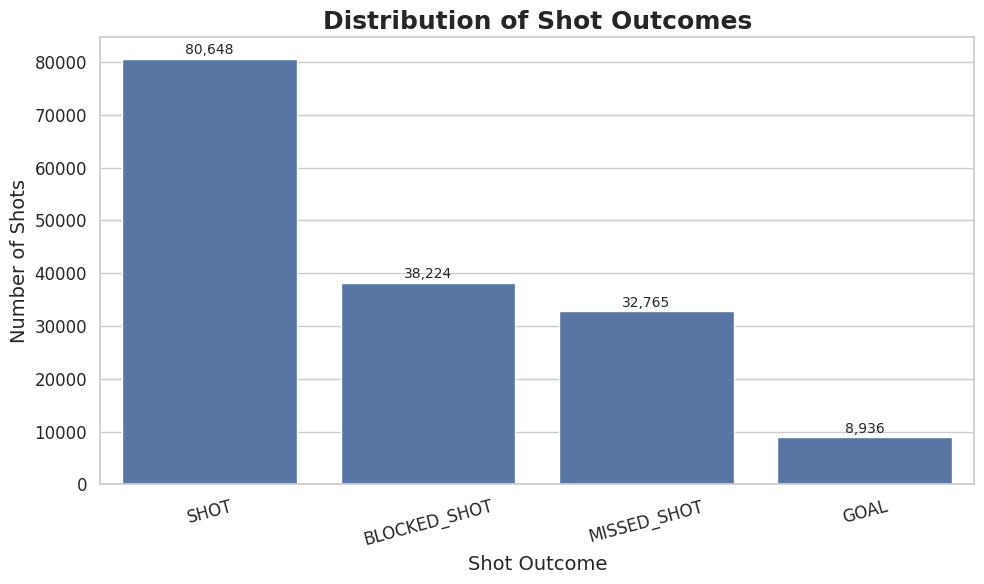

In [4]:
#calculate types of shots and how much per each one

# Clean theme
sns.set_theme(style="whitegrid")

# Count outcomes
shot_outcome_counts = df['shot_outcome'].value_counts().reset_index()
shot_outcome_counts.columns = ['Shot Outcome', 'Count']

# Sort by count
shot_outcome_counts = shot_outcome_counts.sort_values('Count', ascending=False)

#plot
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x='Shot Outcome',
    y='Count',
    data=shot_outcome_counts
)

# Add value labels
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width()/2,
        p.get_height() + max(shot_outcome_counts['Count']) * 0.01,
        f"{int(p.get_height()):,}",
        ha='center', fontsize=10
    )

plt.title('Distribution of Shot Outcomes', fontsize=18, weight='bold')
plt.xlabel('Shot Outcome', fontsize=14)
plt.ylabel('Number of Shots', fontsize=14)

plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


In [5]:
#make new col for the type of shot based on the description

def classify_shot(desc):
    d = desc.lower()

    if "wrist" in d:
        return "wrist"
    if "slap" in d:
        return "slap"
    if "snap" in d:
        return "snap"
    if "tip" in d or "deflect" in d:
        return "tip-in"
    if "backhand" in d:
        return "backhand"
    if "wrap" in d:
        return "wrap_around"

    return "unknown"

df['shot_type'] = df['description'].apply(classify_shot)

# Drop rows where shot_type is "unknown"
df = df[df['shot_type'] != "unknown"]
df.head()

,description,shot_outcome,period,game_seconds_remaining,home_score,away_score,home_name,event_team,empty_net,strength_code,x_fixed,y_fixed,shot_distance,shot_angle,shot_type
0,Steven Stamkos Wrist Shot saved by Tristan Jarry,SHOT,1,3537,0,0,Tampa Bay Lightning,Tampa Bay Lightning,NaN,EV,61.0,-32.0,42.5,48.8,wrist
2,Brock McGinn Wrist Shot saved by Andrei Vasile...,SHOT,1,3496,0,0,Tampa Bay Lightning,Pittsburgh Penguins,NaN,EV,-65.0,19.0,30.6,38.4,wrist
3,Jan Rutta Wrist Shot saved by Tristan Jarry,SHOT,1,3479,0,0,Tampa Bay Lightning,Tampa Bay Lightning,NaN,EV,-8.0,-27.0,100.7,15.6,wrist
4,Danton Heinen Wrist Shot saved by Andrei Vasil...,SHOT,1,3433,0,0,Tampa Bay Lightning,Pittsburgh Penguins,NaN,EV,-60.0,-4.0,29.3,7.9,wrist
5,Ondrej Palat Wrist Shot saved by Tristan Jarry,SHOT,1,3413,0,0,Tampa Bay Lightning,Tampa Bay Lightning,NaN,EV,63.0,4.0,26.3,8.7,wrist


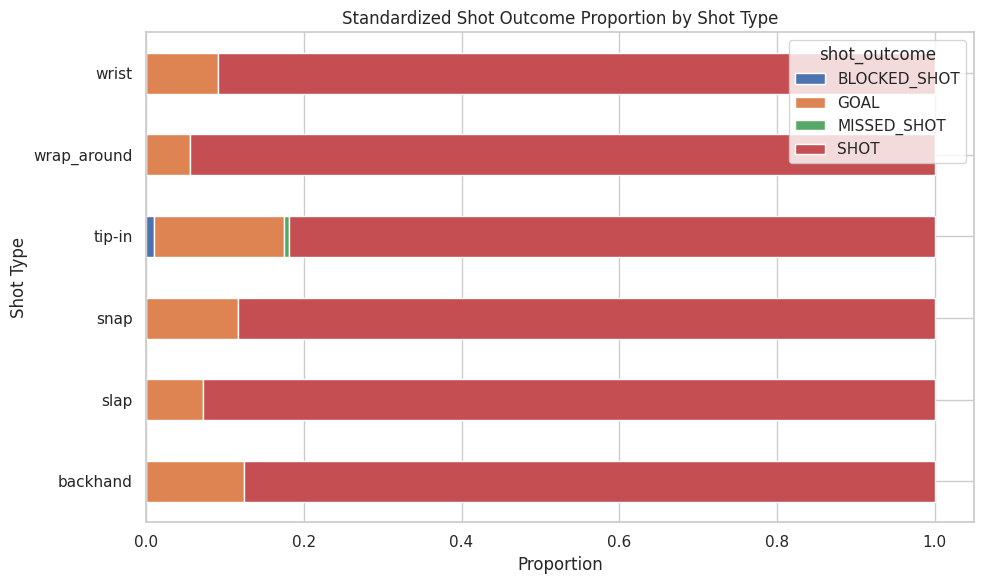

In [6]:
#get the number of each shot outcome for each shot type by proportions so easier to compare

# Count combinations
counts = df.groupby(['shot_type', 'shot_outcome']).size().reset_index(name='count')


# Pivot to get counts
pivot = df.pivot_table(
    index='shot_type',
    columns='shot_outcome',
    aggfunc='size',
    fill_value=0
)

# Standardize rows to proportions
pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)

# Plot
pivot_norm.plot(kind='barh', stacked=True, figsize=(10, 6))

plt.xlabel("Proportion")
plt.ylabel("Shot Type")
plt.title("Standardized Shot Outcome Proportion by Shot Type")
plt.tight_layout()
plt.show()

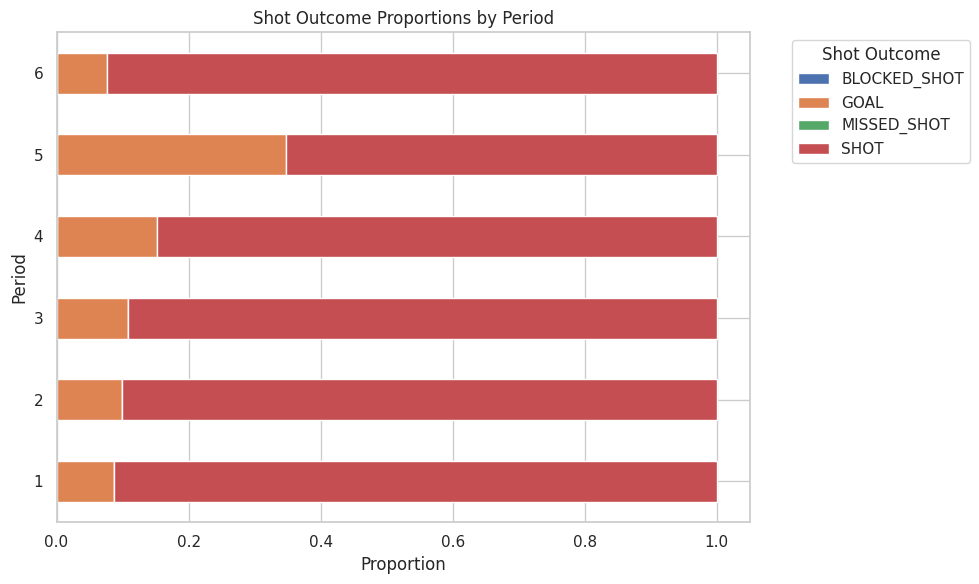

In [7]:
#calculate the number of shot outcomes per period - proportions

# Count outcomes per period
counts = (
    df.groupby(["period", "shot_outcome"])
      .size()
      .reset_index(name="count")
)

#compute proportions
counts["proportion"] = (
    counts["count"] / counts.groupby("period")["count"].transform("sum")
)

# Pivot for stacked bar chart
pivot = counts.pivot(index="period", columns="shot_outcome", values="proportion")

# Plot
pivot.plot(kind="barh", stacked=True, figsize=(10, 6))

plt.title("Shot Outcome Proportions by Period")
plt.xlabel("Proportion")
plt.ylabel("Period")
plt.legend(title="Shot Outcome", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

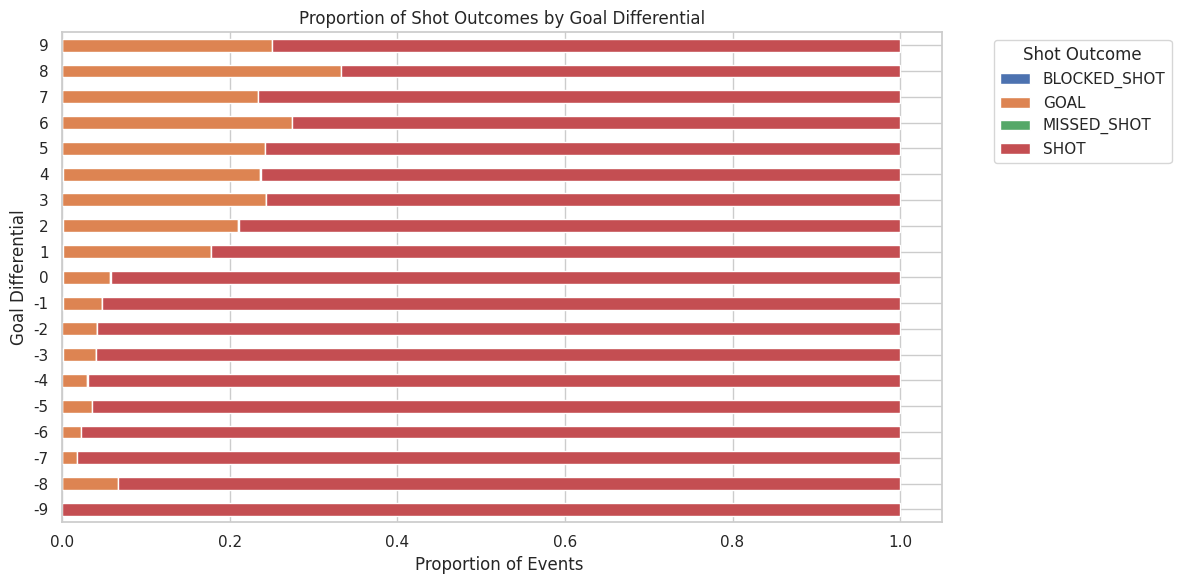

In [8]:
#calculate the number of shot outcomes per goal differential - proportions

#calculate goal differential
df["goal_differential"] = np.where(
    df["event_team"] == df["home_name"],
    df["home_score"] - df["away_score"],
    df["away_score"] - df["home_score"]
)


sns.set_theme(style="whitegrid")

# Count combinations
counts = (
    df.groupby(["goal_differential", "shot_outcome"])
      .size()
      .reset_index(name="count")
)

# compute proportions
counts["proportion"] = (
    counts["count"] / counts.groupby("goal_differential")["count"].transform("sum")
)

# Pivot for plotting
pivot = counts.pivot(
    index="goal_differential",
    columns="shot_outcome",
    values="proportion"
).fillna(0)

# Plot
pivot.plot(
    kind="barh",
    stacked=True,
    figsize=(12, 6)
)

plt.title("Proportion of Shot Outcomes by Goal Differential")
plt.xlabel("Proportion of Events ")
plt.ylabel("Goal Differential")
plt.legend(title="Shot Outcome", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

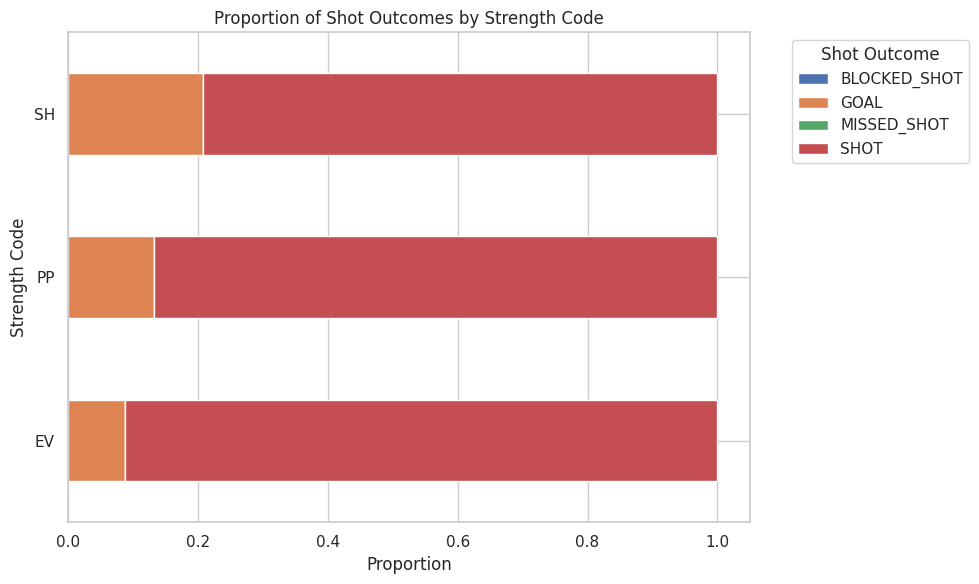

In [9]:
#calculate the number of shot outcomes per strength code - proportions

# Count combinations
counts = (
    df.groupby(["strength_code", "shot_outcome"])
      .size()
      .reset_index(name="count")
)

#proportions
counts["proportion"] = (
    counts["count"] / counts.groupby("strength_code")["count"].transform("sum")
)

# Pivot
pivot = counts.pivot(
    index="strength_code",
    columns="shot_outcome",
    values="proportion"
)

# Plot
pivot.plot(
    kind="barh",
    stacked=True,
    figsize=(10,6)
)

plt.title("Proportion of Shot Outcomes by Strength Code")
plt.xlabel("Proportion")
plt.ylabel("Strength Code")
plt.legend(title="Shot Outcome", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


/tmp/ipython-input-2887219327.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['shot_side', 'angle_bin'])['is_goal']


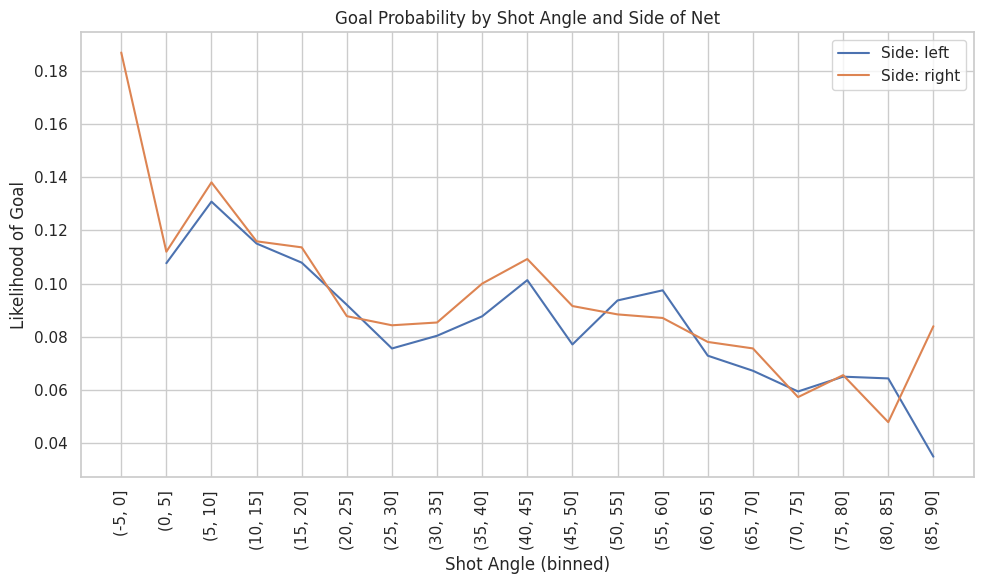

In [10]:
#calculate the probability of goal based on the shot angle


df['is_goal'] = (df['shot_outcome'] == 'GOAL').astype(int)
#goal center y-coordinate is 0
y_center = 0

# Create a column for which side of net the shot comes from and make bins
df['shot_side'] = df['y_fixed'].apply(lambda y: 'left' if y < y_center else 'right')
df['angle_bin'] = pd.cut(df['shot_angle'], bins=range(-90, 95, 5))

#calculate probabilities
angle_side_goal_rates = (
    df.groupby(['shot_side', 'angle_bin'])['is_goal']
       .mean()
       .reset_index(name='goal_prob')
)

#plot
plt.figure(figsize=(10, 6))

for side in angle_side_goal_rates['shot_side'].unique():
    subset = angle_side_goal_rates[angle_side_goal_rates['shot_side'] == side]
    plt.plot(subset['angle_bin'].astype(str),
             subset['goal_prob'],
             label=f"Side: {side}")

plt.xticks(rotation=90)
plt.xlabel("Shot Angle (binned)")
plt.ylabel("Likelihood of Goal")
plt.title("Goal Probability by Shot Angle and Side of Net")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-2871340233.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('distance_bin')['is_goal']


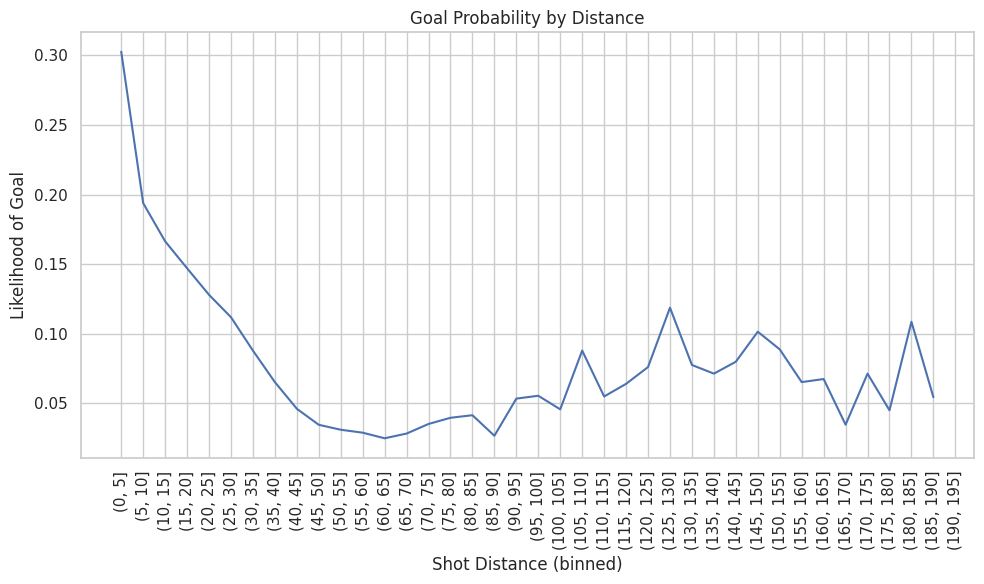

In [11]:
#calculate the probability of goal based on the shot distance

df['distance_bin'] = pd.cut(df['shot_distance'], bins=range(0, 200, 5))

#take all the shots for the bin distance and find the probability of it being a goal. (all the 1s/by all shots)
goal_rates = (
    df.groupby('distance_bin')['is_goal']
       .mean()
       .reset_index()
)

#plot
plt.figure(figsize=(10, 6))

plt.plot(goal_rates['distance_bin'].astype(str),
         goal_rates['is_goal'])

plt.xticks(rotation=90)
plt.xlabel("Shot Distance (binned)")
plt.ylabel("Likelihood of Goal")
plt.title("Goal Probability by Distance")
plt.tight_layout()
plt.show()

In [12]:
#clean again for machine learning

del df["home_name"]
del df["event_team"]
del df["home_score"]
del df["away_score"]
del df["game_seconds_remaining"]
del df["description"]
df.head()

,shot_outcome,period,empty_net,strength_code,x_fixed,y_fixed,shot_distance,shot_angle,shot_type,goal_differential,is_goal,shot_side,angle_bin,distance_bin
0,SHOT,1,NaN,EV,61.0,-32.0,42.5,48.8,wrist,0,0,left,"(45, 50]","(40, 45]"
2,SHOT,1,NaN,EV,-65.0,19.0,30.6,38.4,wrist,0,0,right,"(35, 40]","(30, 35]"
3,SHOT,1,NaN,EV,-8.0,-27.0,100.7,15.6,wrist,0,0,left,"(15, 20]","(100, 105]"
4,SHOT,1,NaN,EV,-60.0,-4.0,29.3,7.9,wrist,0,0,left,"(5, 10]","(25, 30]"
5,SHOT,1,NaN,EV,63.0,4.0,26.3,8.7,wrist,0,0,right,"(5, 10]","(25, 30]"


In [13]:
#hot encode non-numericle values

df["empty_net"] = df["empty_net"].astype(bool).astype(int)
strength_dummies = pd.get_dummies(df["strength_code"], prefix="strength").astype(int)
shot_type_dummies = pd.get_dummies(df["shot_type"], prefix="shot").astype(int)

df = pd.concat([df, strength_dummies, shot_type_dummies], axis=1)

df.head()

#make a copy to use for another ML
df1 = df.copy()



In [14]:
#dop NaN values

df = df.dropna(subset=["period", "empty_net", "x_fixed", "y_fixed", "shot_distance", "shot_angle",
              "goal_differential", "shot_wrist", "shot_backhand", "shot_slap", "shot_snap",
              "shot_tip-in","shot_wrap_around", "strength_EV", "strength_PP", "strength_SH"])
df1 = df1.dropna(subset=["period", "empty_net", "x_fixed", "y_fixed", "shot_distance", "shot_angle",
              "goal_differential", "shot_wrist", "shot_backhand", "shot_slap", "shot_snap",
              "shot_tip-in","shot_wrap_around", "strength_EV", "strength_PP", "strength_SH"])

In [15]:
#create predictors

p1 = ["period", "empty_net", "x_fixed", "y_fixed", "shot_distance", "shot_angle",
              "goal_differential", "shot_wrist", "shot_backhand", "shot_slap", "shot_snap",
              "shot_tip-in","shot_wrap_around", "strength_EV", "strength_PP", "strength_SH"]

#empty net is almost ALWAYS a goal so remove cause its an easy tell
p2= ["period", "x_fixed", "y_fixed", "shot_distance", "shot_angle",
              "goal_differential", "shot_wrist", "shot_backhand", "shot_slap", "shot_snap",
              "shot_tip-in","shot_wrap_around", "strength_EV", "strength_PP", "strength_SH"]


predictors = [p1, p2]


1
Accuracy: 99.09%


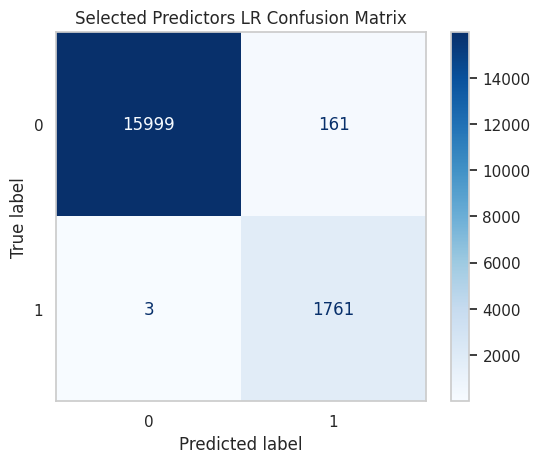

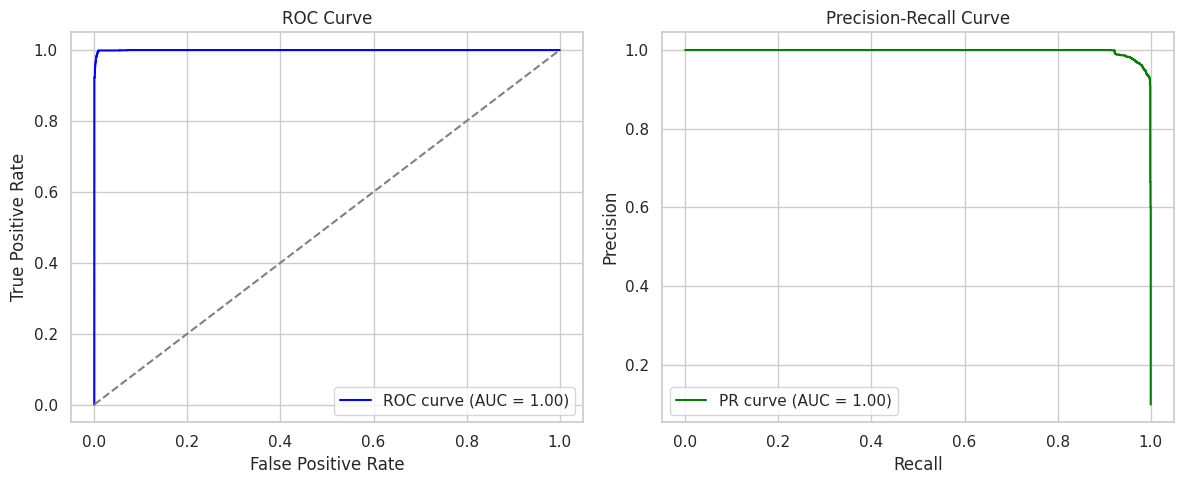

2
Accuracy: 70.69%


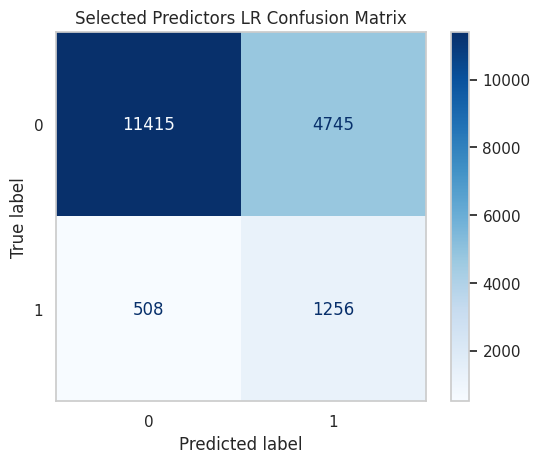

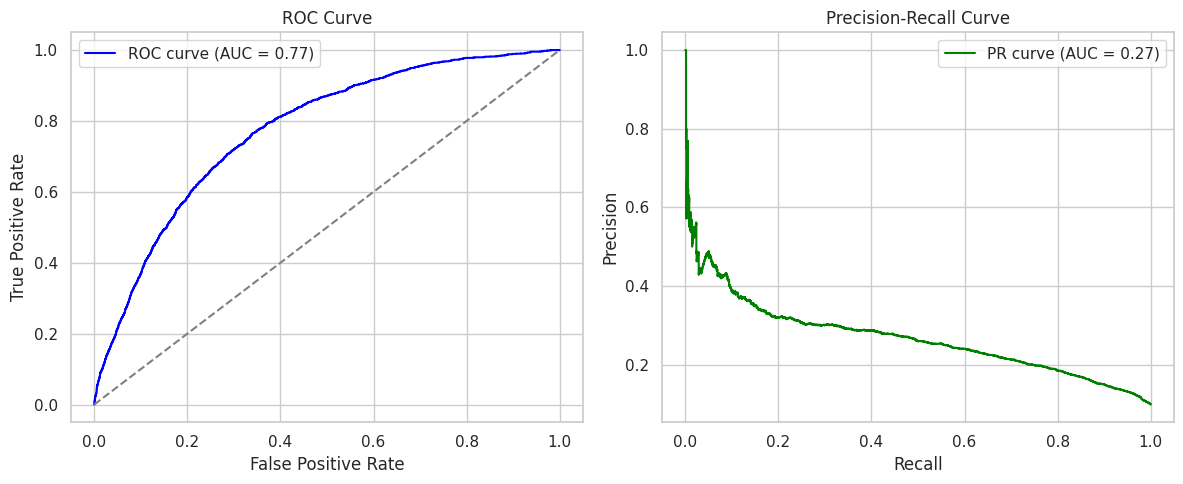

In [16]:
#perform logistical regression to decide if its a goal based on the predictors

i = 1 #make visual part easier to read

#loop through the different lists of predictors
for p in predictors:

  X = df[p].values
  y = df["is_goal"].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  # Split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=0
  )

  # Fit the model
  model = LogisticRegression(class_weight='balanced')
  model.fit(X_train, y_train)

  # Predict
  y_pred = model.predict(X_test)

  print(i)
  i+=1

  #print accuracy and confusion matrix
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: {:.2f}%".format(accuracy * 100))

  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(cm)
  disp.plot(cmap="Blues")
  plt.grid(False)
  plt.title("Selected Predictors LR Confusion Matrix")
  plt.show()


  #compute probabilities for ROC and AUC for more understanding
  y_prob = model.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(12,5))

  # Plot ROC Curve
  plt.subplot(1,2,1)
  plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()

  # Plot Precision-Recall Curve
  precision, recall, _ = precision_recall_curve(y_test, y_prob)
  pr_auc = average_precision_score(y_test, y_prob)

  plt.subplot(1,2,2)
  plt.plot(recall, precision, color='green', label=f'PR curve (AUC = {pr_auc:.2f})')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
feature_names = p2
coeffs = model.coef_[0]   # <-- FIXED
odds_ratios = np.exp(coeffs)

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coeffs,
    "odds_ratio": odds_ratios
})

odds_ratios_df = pd.DataFrame({
    "feature": feature_names,
    "odds_ratio": odds_ratios
})

print(coef_df)


              feature  coefficient  odds_ratio
0              period     0.136192    1.145902
1             x_fixed    -0.044849    0.956142
2             y_fixed     0.029628    1.030071
3       shot_distance    -0.829411    0.436306
4          shot_angle    -0.249039    0.779550
5   goal_differential     0.734529    2.084499
6          shot_wrist    -0.036924    0.963750
7       shot_backhand    -0.059950    0.941812
8           shot_slap     0.027890    1.028283
9           shot_snap     0.067563    1.069898
10        shot_tip-in     0.036030    1.036687
11   shot_wrap_around    -0.077092    0.925805
12        strength_EV    -0.471791    0.623884
13        strength_PP    -0.238975    0.787435
14        strength_SH     0.085460    1.089218


In [ ]:
#label encode to do multinomial regression

le = LabelEncoder()
df1['shot_outcome_label'] = le.fit_transform(df1['shot_outcome'])

In [ ]:
# Map class labels back to shot outcomes for better readability
# LabelEncoder stores the original classes in `classes_` attribute
# The numerical labels correspond to the index of these classes.
class_mapping = dict(enumerate(le.classes_))

# Rename the index of odds_ratio_df to actual outcome names
odds_ratio_df_melted = odds_ratios.reset_index().melt(id_vars='index', var_name='feature', value_name='odds_ratio')
odds_ratio_df_melted.rename(columns={'index': 'outcome_class'}, inplace=True)
odds_ratio_df_melted['outcome_label'] = odds_ratio_df_melted['outcome_class'].map(class_mapping)

# Plotting the odds ratios
plt.figure(figsize=(14, 8))
sns.barplot(x='odds_ratio', y='feature', hue='outcome_label', data=odds_ratio_df_melted, palette='tab10')
plt.axvline(x=1, color='red', linestyle='--', label='No Effect (Odds Ratio = 1)')
plt.title('Feature Impact on Odds Ratios for Different Shot Outcomes (vs. SHOT)')
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.legend(title='Outcome Class')
plt.xscale('log') # Use a log scale for better visualization of widely varying odds ratios
plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 68.46%


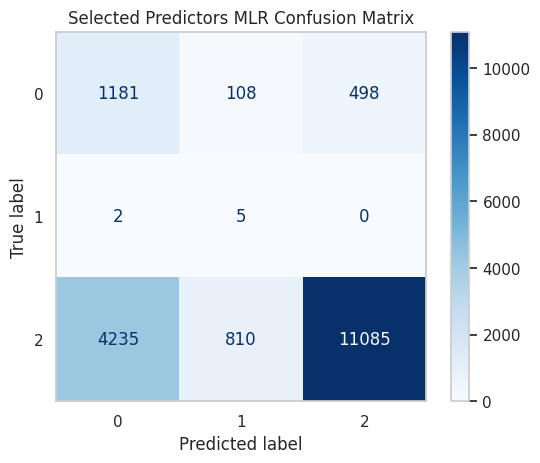

In [ ]:
#perform multinomial logistical regression for the different type of shot outcomes

p2= ["period", "x_fixed", "y_fixed", "shot_distance", "shot_angle",
              "goal_differential", "shot_wrist", "shot_backhand", "shot_slap", "shot_snap",
              "shot_tip-in","shot_wrap_around", "strength_EV", "strength_PP", "strength_SH"]


X = df1[p2].values
y = df1["shot_outcome_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)  # probabilities for each class

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.grid(False)
plt.title("Selected Predictors MLR Confusion Matrix")
plt.show()


In [ ]:
#understand which features impact the classification the most

coef_df = pd.DataFrame(model.coef_, columns=p2, index=model.classes_)
odds_ratio_df = np.exp(coef_df)
odds_ratio_df
coef_long = coef_df.reset_index().melt(id_vars='index', var_name='feature', value_name='coefficient')
coef_long['odds_ratio'] = np.exp(coef_long['coefficient'])
coef_long.rename(columns={'index':'class'}, inplace=True)
coef_long

,class,feature,coefficient,odds_ratio
0,0,period,0.154420,1.166981
1,1,period,-0.128837,0.879117
2,2,period,-0.025583,0.974741
3,0,x_fixed,-0.001974,0.998028
4,1,x_fixed,0.002830,1.002834
5,2,x_fixed,-0.000856,0.999144
6,0,y_fixed,-0.001345,0.998656
7,1,y_fixed,0.003663,1.003670
8,2,y_fixed,-0.002318,0.997684
9,0,shot_distance,-0.052760,0.948608


Accuracy: 88.99%


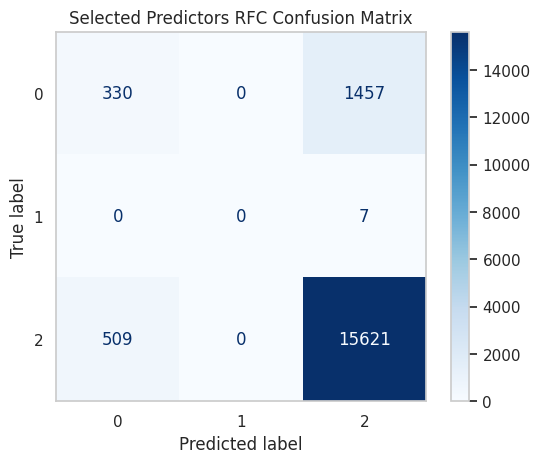

In [ ]:
#see if a random forest classifier prforms better for the multinomial classification

model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)  # probabilities for each class

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.grid(False)
plt.title("Selected Predictors RFC Confusion Matrix")
plt.show()

In [ ]:
# Collecting relevant features

X_xg = df[p2].values
X_xg_scaled = scaler.transform(X_xg)
df['xG'] = model.predict_proba(X_xg_scaled)[:, 1]
df.head()

,shot_outcome,period,empty_net,strength_code,x_fixed,y_fixed,shot_distance,shot_angle,shot_type,goal_differential,...,strength_EV,strength_PP,strength_SH,shot_backhand,shot_slap,shot_snap,shot_tip-in,shot_wrap_around,shot_wrist,xG
0,SHOT,1,1,EV,61.0,-32.0,42.5,48.8,wrist,0,...,1,0,0,0,0,0,0,0,1,0.0
2,SHOT,1,1,EV,-65.0,19.0,30.6,38.4,wrist,0,...,1,0,0,0,0,0,0,0,1,0.0
3,SHOT,1,1,EV,-8.0,-27.0,100.7,15.6,wrist,0,...,1,0,0,0,0,0,0,0,1,0.0
4,SHOT,1,1,EV,-60.0,-4.0,29.3,7.9,wrist,0,...,1,0,0,0,0,0,0,0,1,0.0
5,SHOT,1,1,EV,63.0,4.0,26.3,8.7,wrist,0,...,1,0,0,0,0,0,0,0,1,0.0


In [ ]:
# Re-train binary Logistic Regression model and scaler specifically for xG calculation.

X_xg_calc = df[p2].values
y_xg_calc = df["is_goal"].values

binary_scaler = StandardScaler()
X_xg_calc_scaled = binary_scaler.fit_transform(X_xg_calc)

binary_log_reg_model = LogisticRegression(class_weight='balanced')
binary_log_reg_model.fit(X_xg_calc_scaled, y_xg_calc)

print("Dedicated binary Logistic Regression model and scaler trained for xG calculation.")

Dedicated binary Logistic Regression model and scaler trained for xG calculation.


In [ ]:
# Collecting relevant features and calculating xG

X_xg = df[p2].values
X_xg_scaled = binary_scaler.transform(X_xg)
df['xG'] = binary_log_reg_model.predict_proba(X_xg_scaled)[:, 1]
df.head()

,shot_outcome,period,empty_net,strength_code,x_fixed,y_fixed,shot_distance,shot_angle,shot_type,goal_differential,...,strength_EV,strength_PP,strength_SH,shot_backhand,shot_slap,shot_snap,shot_tip-in,shot_wrap_around,shot_wrist,xG
0,SHOT,1,1,EV,61.0,-32.0,42.5,48.8,wrist,0,...,1,0,0,0,0,0,0,0,1,0.202228
2,SHOT,1,1,EV,-65.0,19.0,30.6,38.4,wrist,0,...,1,0,0,0,0,0,0,0,1,0.329499
3,SHOT,1,1,EV,-8.0,-27.0,100.7,15.6,wrist,0,...,1,0,0,0,0,0,0,0,1,0.056127
4,SHOT,1,1,EV,-60.0,-4.0,29.3,7.9,wrist,0,...,1,0,0,0,0,0,0,0,1,0.415368
5,SHOT,1,1,EV,63.0,4.0,26.3,8.7,wrist,0,...,1,0,0,0,0,0,0,0,1,0.419445


In [ ]:
# Setting a threshold for if a shot has high or low probability

xg_threshold = df['xG'].quantile(0.75)
if xg_threshold == 0:
    xg_threshold = 0.01

df['xG_category'] = df['xG'].apply(lambda x: 'high probability' if x >= xg_threshold else 'low probability')
print(f"New xG threshold for high probability shots: {xg_threshold:.4f}")
df.head()

New xG threshold for high probability shots: 0.5684


,shot_outcome,period,empty_net,strength_code,x_fixed,y_fixed,shot_distance,shot_angle,shot_type,goal_differential,...,strength_PP,strength_SH,shot_backhand,shot_slap,shot_snap,shot_tip-in,shot_wrap_around,shot_wrist,xG,xG_category
0,SHOT,1,1,EV,61.0,-32.0,42.5,48.8,wrist,0,...,0,0,0,0,0,0,0,1,0.202228,low probability
2,SHOT,1,1,EV,-65.0,19.0,30.6,38.4,wrist,0,...,0,0,0,0,0,0,0,1,0.329499,low probability
3,SHOT,1,1,EV,-8.0,-27.0,100.7,15.6,wrist,0,...,0,0,0,0,0,0,0,1,0.056127,low probability
4,SHOT,1,1,EV,-60.0,-4.0,29.3,7.9,wrist,0,...,0,0,0,0,0,0,0,1,0.415368,low probability
5,SHOT,1,1,EV,63.0,4.0,26.3,8.7,wrist,0,...,0,0,0,0,0,0,0,1,0.419445,low probability


In [ ]:
# Print the number of high probability shots

high_prob_shots = df[df['xG_category'] == 'high probability'].shape[0]
print(f"Number of high probability shots: {high_prob_shots}")

Number of high probability shots: 22405


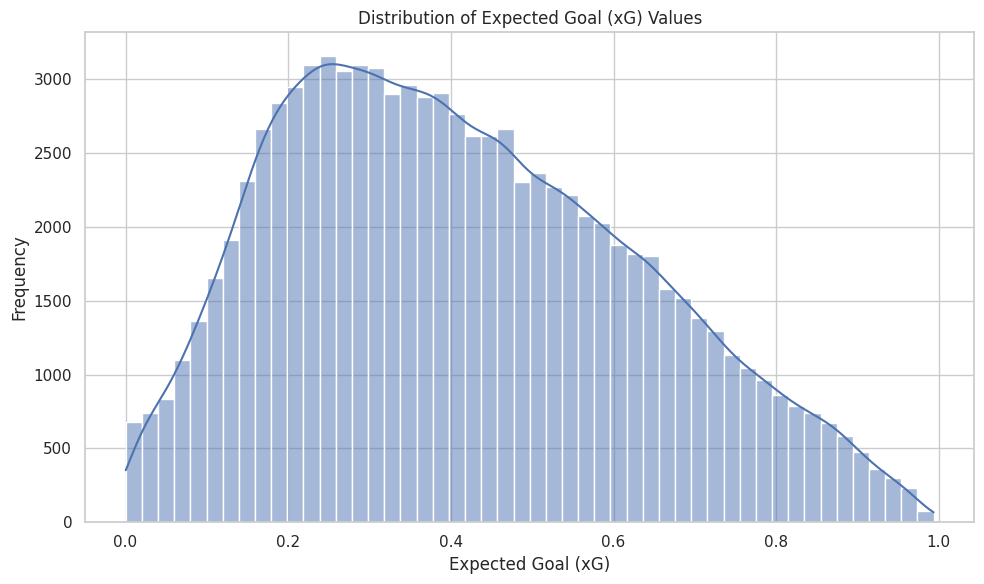

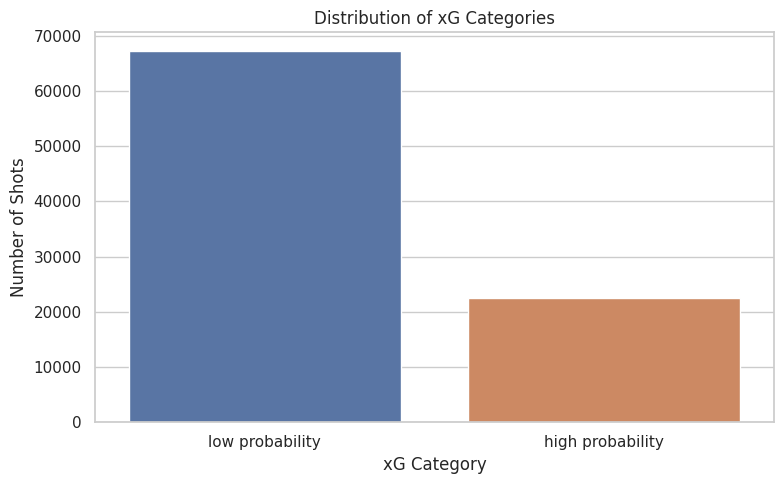

        xG_category   is_goal
0  high probability  0.242892
1   low probability  0.051939


In [ ]:
# Plots to help show the distribution of shots

plt.figure(figsize=(10, 6))
sns.histplot(df['xG'], bins=50, kde=True)
plt.title('Distribution of Expected Goal (xG) Values')
plt.xlabel('Expected Goal (xG)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='xG_category', data=df, hue='xG_category', legend=False)
plt.title('Distribution of xG Categories')
plt.xlabel('xG Category')
plt.ylabel('Number of Shots')
plt.tight_layout()
plt.show()

goal_conversion_rates = df.groupby('xG_category')['is_goal'].mean().reset_index()
print(goal_conversion_rates)

In [ ]:
# Summary of shot type

shot_type_summary = df.groupby('shot_type').agg(
    num_shots=('shot_type', 'count'),
    num_goals=('is_goal', 'sum'),
    avg_goal_rate=('is_goal', 'mean')
).reset_index()

print("Shot Type Summary:")
display(shot_type_summary)

Shot Type Summary:


,shot_type,num_shots,num_goals,avg_goal_rate
0,backhand,7133,885,0.124071
1,slap,11479,829,0.072219
2,snap,11875,1378,0.116042
3,tip-in,6548,1093,0.166921
4,wrap_around,776,43,0.055412
5,wrist,51807,4705,0.090818


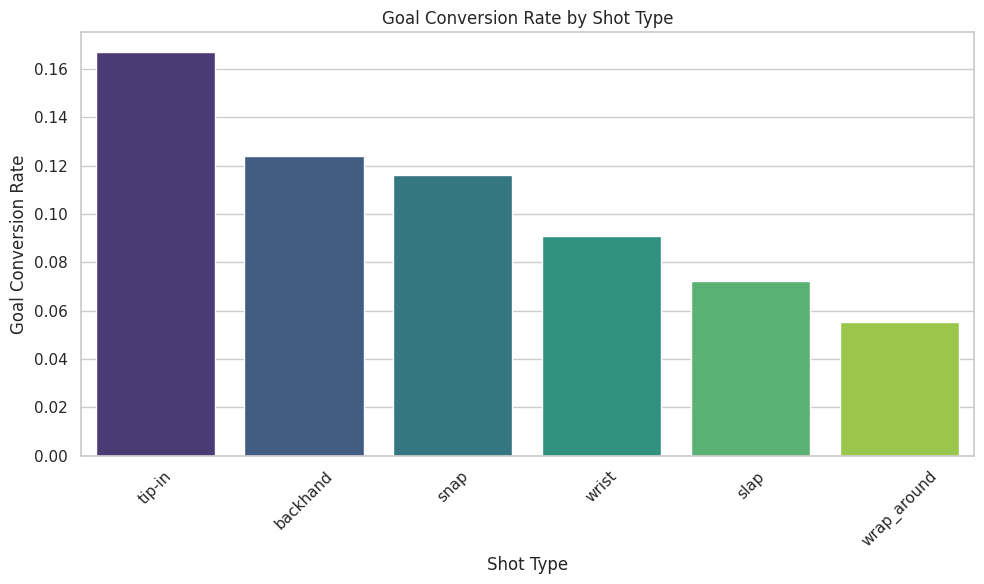

In [ ]:
# Histogram sorted by shot type and the goal conversion rate

shot_type_goal_rates = df.groupby('shot_type')['is_goal'].mean().reset_index()
shot_type_goal_rates = shot_type_goal_rates.sort_values(by='is_goal', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='shot_type', y='is_goal', data=shot_type_goal_rates, hue='shot_type', palette='viridis', legend=False)
plt.title('Goal Conversion Rate by Shot Type')
plt.xlabel('Shot Type')
plt.ylabel('Goal Conversion Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical

X = df1[p2].values
y = df1['shot_outcome_label'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
y_train_nn_encoded = to_categorical(y_train_nn)
y_test_nn_encoded = to_categorical(y_test_nn)

print("Data prepared for Neural Network:")
print(f"X_train_nn shape: {X_train_nn.shape}")
print(f"y_train_nn_encoded shape: {y_train_nn_encoded.shape}")
print(f"X_test_nn shape: {X_test_nn.shape}")
print(f"y_test_nn_encoded shape: {y_test_nn_encoded.shape}")

Data prepared for Neural Network:
X_train_nn shape: (71694, 15)
y_train_nn_encoded shape: (71694, 3)
X_test_nn shape: (17924, 15)
y_test_nn_encoded shape: (17924, 3)


In [ ]:
#!pip install -U scikeras scikit-learn


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Number of classes (set manually)
output_dim = y_train_nn_encoded.shape[1]   # OK

# 1️⃣ Build function for SciKeras
def create_model(neurons1=128, neurons2=64, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_shape=(X_train_nn.shape[1],)))
    model.add(Dense(neurons2, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# 2️⃣ Wrap the model for sklearn
keras_clf = KerasClassifier(
    model=create_model,
    verbose=0
)

# 3️⃣ Define parameter grid (NO model__)
param_grid = {
    "model__neurons1": [64, 128],
    "model__neurons2": [32, 64],
    "model__learning_rate": [0.001, 0.0005],
    "batch_size": [16, 32],
    "epochs": [15, 25]
}

# 4️⃣ Run GridSearchCV
grid = GridSearchCV(
    estimator=keras_clf,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

grid_result = grid.fit(X_train_nn, y_train_nn_encoded)

print("Best params:", grid_result.best_params_)
print("Best accuracy:", grid_result.best_score_)

# 5️⃣ Final model after tuning
best_model = grid_result.best_estimator_

#


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best params: {'batch_size': 16, 'epochs': 15, 'model__learning_rate': 0.001, 'model__neurons1': 64, 'model__neurons2': 64}
Best accuracy: 0.9047758529305102


In [ ]:
loss, accuracy = model.evaluate(X_test_nn, y_test_nn_encoded, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}%")

# Get predicted class probabilities
y_pred_nn_encoded = model.predict(X_test_nn)

# Convert one-hot encoded predictions and true labels to class labels
y_pred_nn = np.argmax(y_pred_nn_encoded, axis=1)
y_true_nn = np.argmax(y_test_nn_encoded, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_nn, y_pred_nn, target_names=le.classes_))

# Generate and display confusion matrix
cm_nn = confusion_matrix(y_true_nn, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=le.classes_)
plt.figure(figsize=(8, 6))
disp_nn.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.grid(False)
plt.title('Neural Network Confusion Matrix')
plt.show()

In [ ]:
# Convert numerical labels back to original string labels
y_true_labels = le.inverse_transform(y_true_nn)
y_pred_labels = le.inverse_transform(y_pred_nn)

# Create a DataFrame for easier plotting
plot_df = pd.DataFrame({
    'Outcome Type': ['Actual'] * len(y_true_labels) + ['Predicted'] * len(y_pred_labels),
    'Shot Outcome': list(y_true_labels) + list(y_pred_labels)
})

plt.figure(figsize=(12, 6))
sns.countplot(x='Shot Outcome', hue='Outcome Type', data=plot_df, palette={'Actual': 'skyblue', 'Predicted': 'lightcoral'})
plt.title('Distribution of Actual vs. Predicted Shot Outcomes')
plt.xlabel('Shot Outcome')
plt.ylabel('Count')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_nn.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train_nn_encoded.shape[1], activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
# Training neural network
history = model.fit(
    X_train_nn,
    y_train_nn_encoded,
    epochs=25,
    batch_size=32,
    validation_data=(X_test_nn, y_test_nn_encoded)
)